<a href="https://colab.research.google.com/github/amarskawale/Image_generation_using_GAN/blob/main/GAN_ANIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opendatasets --upgrade


In [2]:
# /content/drive/MyDrive/Kaggle_key/kaggle.json

# /content/animefacedataset

In [3]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: "amarsinhakawale"
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:02<00:00, 148MB/s]


In [4]:
import os

DATA_DIR='/content/animefacedataset'
print((os.listdir(DATA_DIR)))

['images']


In [5]:
from torch.utils.data import dataloader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size=64
Batch_size=64

stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [7]:
train_ds=ImageFolder(DATA_DIR,transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl=dataloader.DataLoader(train_ds,
                               Batch_size,
                               shuffle=True,
                               num_workers=3,
                               pin_memory=True)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def denorm(img_tensor):
    return img_tensor*stats[1][0]+stats[0][0]

In [10]:
def show_images(images,nmax=64):
    fig,ax=plt.subplots(figsize=(8,8))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))
    plt.show()

def show_batch(dl,nmax=64):
  for images, _ in dl:
    show_images(images,nmax)
    break

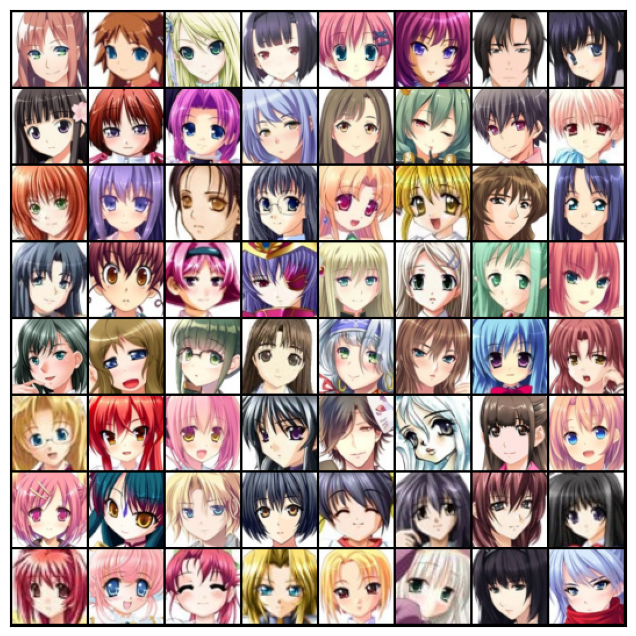

In [11]:
show_batch(train_dl)

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

In [15]:
import torch.nn as nn

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator = to_device(discriminator, device)

In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([64, 3, 64, 64])


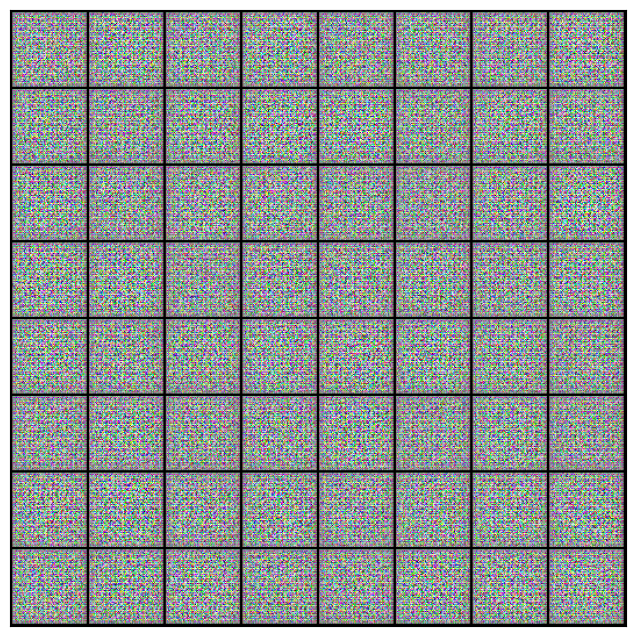

In [21]:
xb = torch.randn(Batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [22]:
generator = to_device(generator, device)

In [55]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(Batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [56]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(Batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(Batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [46]:
from torchvision.utils import save_image

In [47]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [57]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [58]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


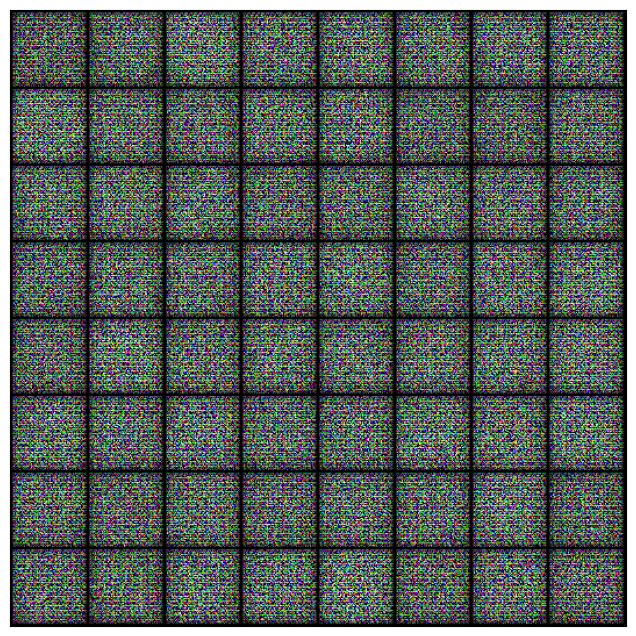

In [59]:
save_samples(0, fixed_latent)

In [60]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [61]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [62]:
lr = 0.0002
epochs = 25

In [63]:

history = fit(epochs, lr)

  0%|          | 0/994 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/25], loss_g: 4.6031, loss_d: 0.2885, real_score: 0.8084, fake_score: 0.0349
Saving generated-images-0001.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 7.1205, loss_d: 0.6084, real_score: 0.6283, fake_score: 0.0019
Saving generated-images-0002.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 7.5856, loss_d: 0.0727, real_score: 0.9345, fake_score: 0.0017
Saving generated-images-0003.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 2.2406, loss_d: 0.3265, real_score: 0.8064, fake_score: 0.0241
Saving generated-images-0004.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 6.0556, loss_d: 0.0365, real_score: 0.9718, fake_score: 0.0072
Saving generated-images-0005.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 4.9452, loss_d: 0.0826, real_score: 0.9756, fake_score: 0.0523
Saving generated-images-0006.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 2.8082, loss_d: 0.2531, real_score: 0.8340, fake_score: 0.0243
Saving generated-images-0007.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 7.9174, loss_d: 0.0326, real_score: 0.9995, fake_score: 0.0306
Saving generated-images-0008.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 2.7103, loss_d: 0.3902, real_score: 0.8257, fake_score: 0.0327
Saving generated-images-0009.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 5.4978, loss_d: 0.0954, real_score: 0.9598, fake_score: 0.0433
Saving generated-images-0010.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 7.3110, loss_d: 0.0255, real_score: 0.9774, fake_score: 0.0016
Saving generated-images-0011.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 1.6715, loss_d: 0.5447, real_score: 0.6415, fake_score: 0.0062
Saving generated-images-0012.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.8554, loss_d: 0.3282, real_score: 0.7912, fake_score: 0.0278
Saving generated-images-0013.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 2.1278, loss_d: 0.3062, real_score: 0.8115, fake_score: 0.0126
Saving generated-images-0014.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 6.8078, loss_d: 0.0804, real_score: 0.9780, fake_score: 0.0503
Saving generated-images-0015.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 1.2771, loss_d: 0.2701, real_score: 0.8148, fake_score: 0.0454
Saving generated-images-0016.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.3272, loss_d: 0.0911, real_score: 0.9524, fake_score: 0.0359
Saving generated-images-0017.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 5.5500, loss_d: 0.1760, real_score: 0.9901, fake_score: 0.1321
Saving generated-images-0018.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 5.8141, loss_d: 0.1730, real_score: 0.9991, fake_score: 0.1377
Saving generated-images-0019.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 7.1581, loss_d: 0.0174, real_score: 0.9983, fake_score: 0.0153
Saving generated-images-0020.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 1.6973, loss_d: 0.2187, real_score: 0.8481, fake_score: 0.0248
Saving generated-images-0021.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 6.9705, loss_d: 0.0121, real_score: 0.9911, fake_score: 0.0031
Saving generated-images-0022.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.2625, loss_d: 0.0838, real_score: 0.9391, fake_score: 0.0176
Saving generated-images-0023.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 5.5513, loss_d: 0.0694, real_score: 0.9592, fake_score: 0.0238
Saving generated-images-0024.png


  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 6.4223, loss_d: 0.0380, real_score: 0.9894, fake_score: 0.0265
Saving generated-images-0025.png


In [65]:
losses_g, losses_d, real_scores, fake_scores = history

In [66]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [67]:
from IPython.display import Image

In [68]:
from IPython.display import Image

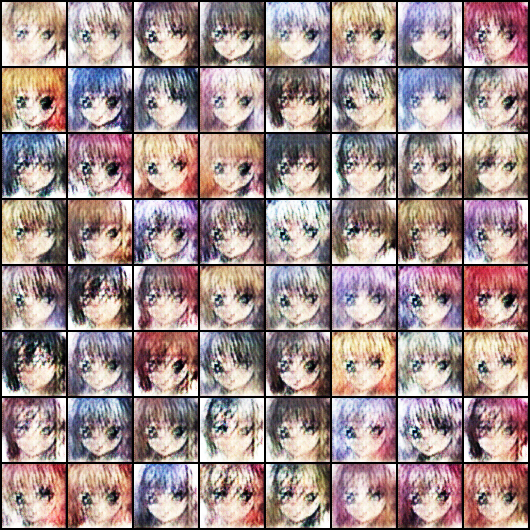

In [69]:
Image('./generated/generated-images-0001.png')

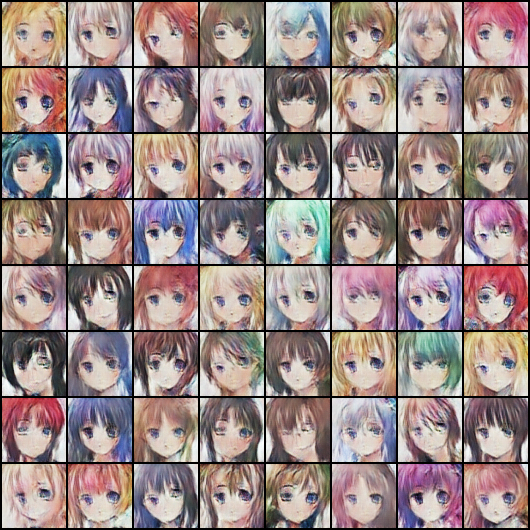

In [70]:
Image('./generated/generated-images-0005.png')

In [71]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

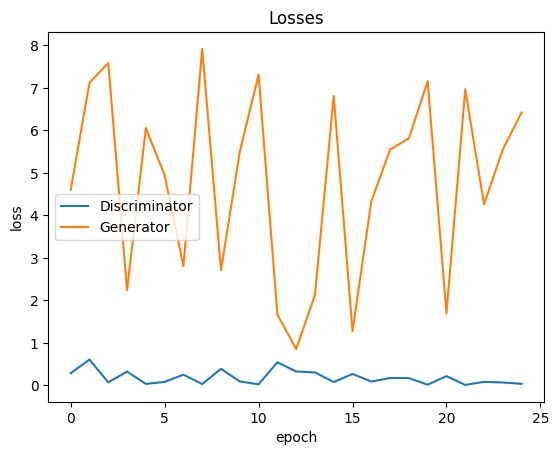

In [72]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

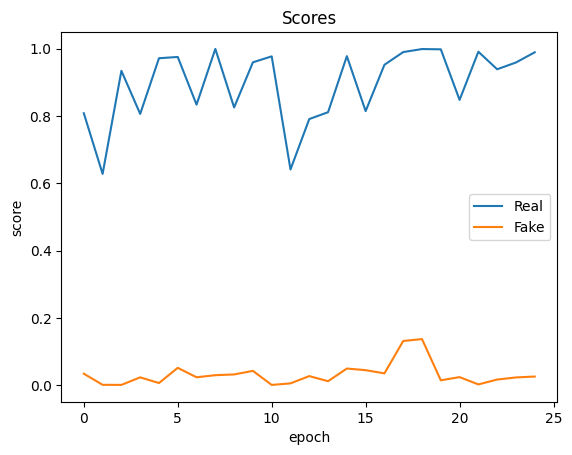

In [73]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');